# Check outputs of MODIS_HRRR processing 
*J. Michelle Hu  
University of Utah  
August 2024*  
---

In [1]:
import os
import sys
import xarray as xr
import numpy as np

import pandas as pd
import matplotlib.pyplot as plt

sys.path.append('/uufs/chpc.utah.edu/common/home/u6058223/git_dirs/env/')
import helpers as h

sys.path.append('/uufs/chpc.utah.edu/common/home/u6058223/git_dirs/ucrb-isnobal/scripts/')
import processing as proc


In [2]:
%reload_ext autoreload
%autoreload 2

In [3]:
# Set environmental variable for PROJ to directory where you can find proj.db
os.environ['PROJ']='/uufs/chpc.utah.edu/common/home/u6058223/software/pkg/miniconda3/pkgs/proj-9.3.1-h1d62c97_0/share/proj'
os.environ['PROJLIB']='/uufs/chpc.utah.edu/common/home/u6058223/software/pkg/miniconda3/pkgs/proj-9.3.1-h1d62c97_0/share/proj'

## Directory

In [4]:
# basin = 'blue_river'
# basin = 'yampa'
basin = 'animas'

In [5]:
workdir = '/uufs/chpc.utah.edu/common/home/skiles-group1/jmhu/model_runs/'
# basindirs = h.fn_list(workdir, f'__{basin}*')
# basindirs = [h.fn_list(workdir, f'__{basin}*')[1], h.fn_list(workdir, f'{basin}*')[0]]
basindirs = [h.fn_list(workdir, f'*{basin}*')[0], h.fn_list(workdir, f'*{basin}*')[1]]
basindirs

['/uufs/chpc.utah.edu/common/home/skiles-group1/jmhu/model_runs/__animas_100m_isnobal',
 '/uufs/chpc.utah.edu/common/home/skiles-group1/jmhu/model_runs/__animas_100m_isnobal_solar_albedo']

In [6]:
# __blue_river_100m_isnobal_solar_albedo = original run
# _20240825_blue_river_100m_isnobal_solar_albedo = re-run from  yesterday

In [7]:
# h.fn_list(workdir, f'*{basin}*')

In [8]:
# Get the WY from the directory name
WY = int(h.fn_list(basindirs[0], '*')[0].split('/')[-1].split('wy')[-1])
WY

2021

## Specify a point for evaluation

In [9]:
snotel_dir = '/uufs/chpc.utah.edu/common/home/skiles-group3/SNOTEL'

Retrieved geodataframe of Cascade #2 (387) SNOTEL site and dataframe for WY 2021


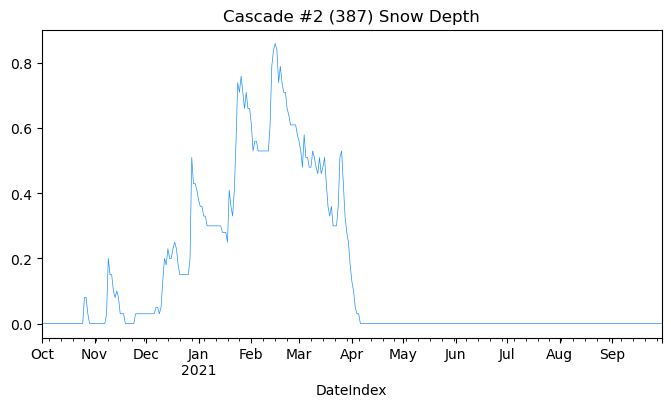

In [10]:
from shapely.geometry import Point
import geopandas as gpd

# TODO: add data to locate snotel within basin
script_dir = '/uufs/chpc.utah.edu/common/home/skiles-group1/jmhu/isnobal_scripts'

# Basin polygon file
poly_fn = h.fn_list(script_dir, f'*{basin}*setup/polys/*shp')[0]

# SNOTEL all sites geojson fn
allsites_fn = h.fn_list(snotel_dir, 'snotel_sites_32613.json')[0]

# Locate SNOTEL sites within basin
found_sites = proc.locate_snotel_in_poly(poly_fn=poly_fn, site_locs_fn=allsites_fn)

# Get site names and site numbers
site_names = found_sites['site_name']
sitenums = found_sites['site_num']

snotel_df, gdf, sitenum, sitename = proc.get_snotel_df_pt(snotel_dir=snotel_dir, sitenums=sitenums, WY=WY)
linestyle = '-' #':'
linewidth = 0.5
marker = None
color = 'k'
snotelcolors = ['dodgerblue', 'gray']

figsize = (8,4)
fig, ax = plt.subplots (1, figsize=figsize)
(snotel_df[f'{sitename} Snow Depth (cm) End of Day Values']/100).plot(ax=ax, 
                                                                label=f'{sitename} Snow Depth [m]', 
                                                                linestyle=linestyle, 
                                                                linewidth=linewidth, 
                                                                color=snotelcolors[0], 
                                                                marker=marker
                                                                )
plt.title(f'{sitename} Snow Depth');

# Check MODIS HRRR outputs on their own

## Check out net_solar

In [11]:
basindirs

['/uufs/chpc.utah.edu/common/home/skiles-group1/jmhu/model_runs/__animas_100m_isnobal',
 '/uufs/chpc.utah.edu/common/home/skiles-group1/jmhu/model_runs/__animas_100m_isnobal_solar_albedo']

In [14]:
%%time
# currently for one WY (only one per basin as of 20240618), will need to add more for WYs in the future
month = 'run20'
days = h.fn_list(basindirs[0], f"*/*/{month}*/smrf_energy_balance*.nc")
if len(days) == 0:
    days = h.fn_list(basindirs[0], f"*/*/{month}*/net_solar*.nc")
days = [days, h.fn_list(basindirs[1], f"*/*/{month}*/net_solar.nc")]

print(len(days[0]), len(days[1]))

351 365
CPU times: user 54.2 ms, sys: 75.8 ms, total: 130 ms
Wall time: 9.41 s


In [15]:
# # Read in datasets
# isnobal_hrrr_list = [xr.open_dataset(day_fn) for day_fn in days[0]]
# modis_hrrr_list = [xr.open_dataset(day_fn) for day_fn in days[1]]

In [27]:
# Try to do this in parallel
isnobal_hrrr_ds = xr.open_mfdataset(days[0][:350], parallel=True)

# Try to do this in parallel
modis_hrrr_ds = xr.open_mfdataset(days[1][:350], parallel=True)

In [30]:
isnobal_hrrr_list = isnobal_hrrr_ds
modis_hrrr_list = modis_hrrr_ds

In [32]:
isnobal_hrrr_ds

<xarray.Dataset> Size: 14GB
Dimensions:     (time: 8400, y: 820, x: 492)
Coordinates:
  * time        (time) datetime64[ns] 67kB 2020-10-01 ... 2021-09-15T23:00:00
  * y           (y) float32 3kB 4.205e+06 4.205e+06 ... 4.123e+06 4.123e+06
  * x           (x) float32 2kB 2.299e+05 2.3e+05 ... 2.789e+05 2.79e+05
Data variables:
    net_solar   (time, y, x) float32 14GB dask.array<chunksize=(1, 820, 492), meta=np.ndarray>
    projection  (time) |S1 8kB b'' b'' b'' b'' b'' b'' ... b'' b'' b'' b'' b''
Attributes:
    Conventions:   CF-1.6
    dateCreated:   2024-06-14 13:12:52
    title:         Distributed Net solar radiation data from SMRF
    history:       [2024-06-14 13:12:52] Create netCDF4 file
    institution:   USDA Agricultural Research Service, Northwest Watershed Re...
    references:    Online documentation smrf.readthedocs.io; https://doi.org/...
    SMRF_version:  unknown

In [33]:
# Pull net_solar
thisvar = 'net_solar'
var_data = isnobal_hrrr_ds[thisvar].sel(x=list(gdf.geometry.x.values), y=list(gdf.geometry.y.values), method='nearest')
updated_var_data = modis_hrrr_ds[thisvar].sel(x=list(gdf.geometry.x.values), y=list(gdf.geometry.y.values), method='nearest')

# # Concatenate all the days
# var_data = xr.concat(var_data, dim='time')
# updated_var_data = xr.concat(updated_var_data, dim='time')


In [43]:
var_data

<xarray.DataArray 'net_solar' (time: 8400, y: 1, x: 1)> Size: 34kB
dask.array<getitem, shape=(8400, 1, 1), dtype=float32, chunksize=(1, 1, 1), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 67kB 2020-10-01 ... 2021-09-15T23:00:00
  * y        (y) float32 4B 4.172e+06
  * x        (x) float32 4B 2.53e+05
Attributes:
    module:        solar
    units:         watt/m2
    long_name:     Net solar radiation
    grid_mapping:  projection

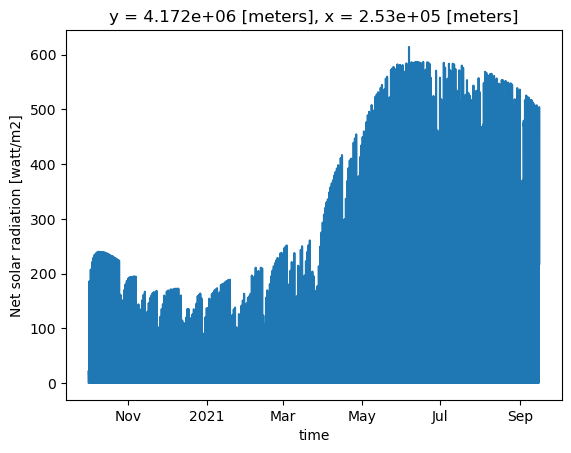

In [45]:
var_data.plot()

In [47]:
# # Pull net_solar
# thisvar = 'net_solar'
# var_data = [ds[thisvar].sel(x=list(gdf.geometry.x.values), y=list(gdf.geometry.y.values), method='nearest') for ds in isnobal_hrrr_list]
# updated_var_data = [ds[thisvar].sel(x=list(gdf.geometry.x.values), y=list(gdf.geometry.y.values), method='nearest') for ds in modis_hrrr_list]

# # Concatenate all the days
# var_data = xr.concat(var_data, dim='time')
# updated_var_data = xr.concat(updated_var_data, dim='time')


In [48]:
figsize = (18, 4)
linestyles = ['-', '--']
linewidth = 1
marker = None
color = 'k'
snotelcolors = ['dodgerblue', 'gray']
isnobalcolors = ['k', 'coral']

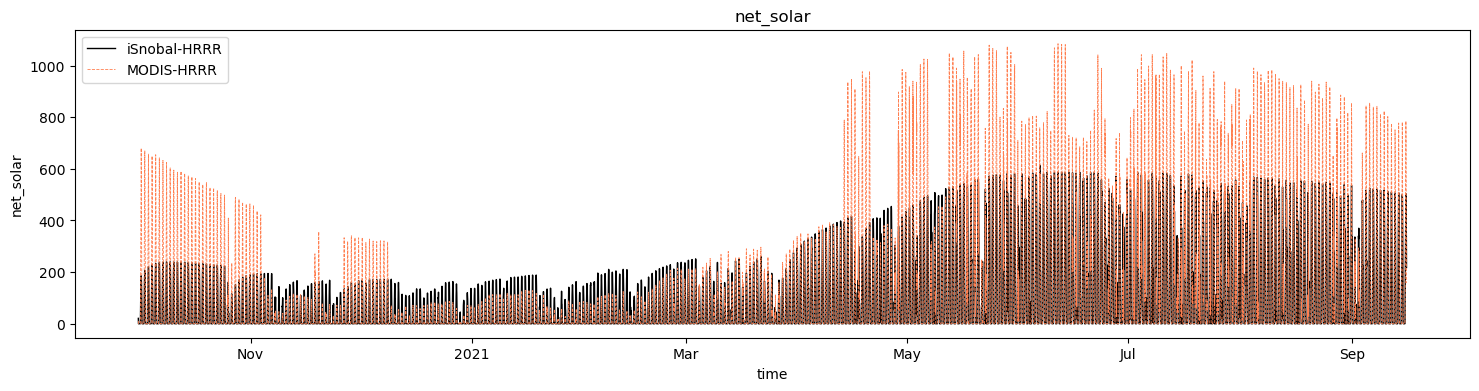

In [49]:
fig, ax = plt.subplots(1, figsize=figsize)
var_data.plot(ax=ax, 
            #   linestyle=linestyles[0], 
              color=isnobalcolors[0], label='iSnobal-HRRR', linewidth=1) 
updated_var_data.plot(ax=ax, linestyle=linestyles[1], color=isnobalcolors[1], label='MODIS-HRRR', linewidth=0.6)

plt.legend()
plt.title(thisvar);

## Check out cloud factor

In [50]:
# currently for one WY (only one per basin as of 20240618), will need to add more for WYs in the future
month = 'run20'
days = h.fn_list(basindirs[0], f"*/*/{month}*/cloud_factor.nc")
days = [days, h.fn_list(basindirs[1], f"*/*/{month}*/cloud_factor.nc")]
len(days), len(days[0]), len(days[1])

(2, 351, 365)

In [51]:
%%time
cloud_list = [xr.open_dataset(day_fn) for day_fn in days[0]]
tcdc_list = [xr.open_dataset(day_fn) for day_fn in days[1]]

CPU times: user 8.57 s, sys: 2.55 s, total: 11.1 s
Wall time: 39.6 s


In [54]:
%%time
thisvar = 'Cloud Factor'
var_data = [ds['cloud_factor'].sel(x=list(gdf.geometry.x.values), y=list(gdf.geometry.y.values), method='nearest') for ds in cloud_list]
# var_data = [ds['TCDC'].sel(x=list(gdf.geometry.x.values), y=list(gdf.geometry.y.values), method='nearest') for ds in cloud_list]
updated_var_data = [ds['TCDC'].sel(x=list(gdf.geometry.x.values), y=list(gdf.geometry.y.values), method='nearest') for ds in tcdc_list]

# Concatenate all the days
var_data = xr.concat(var_data, dim='time')
updated_var_data = xr.concat(updated_var_data, dim='time')

CPU times: user 17 s, sys: 19 s, total: 36.1 s
Wall time: 1min 8s


KeyboardInterrupt: 

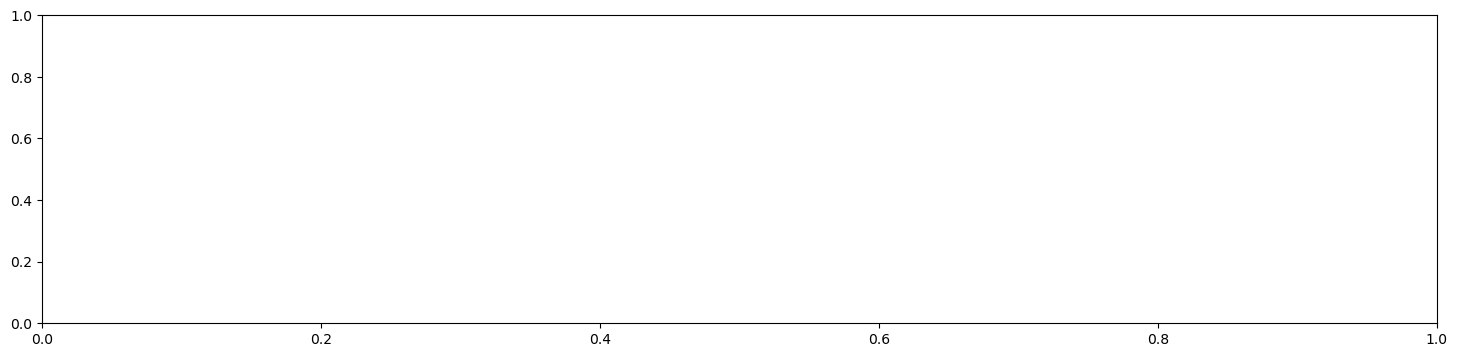

In [53]:
%%time
fig, ax = plt.subplots(1, figsize=figsize)
var_data.plot(ax=ax, 
            #   linestyle=linestyles[0], 
              color='gray', label='iSnobal-HRRR', linewidth=1) 
updated_var_data.plot(ax=ax, linestyle=linestyles[1], color=isnobalcolors[1], label='MODIS-HRRR', linewidth=0.6, alpha=0.6
                      )
plt.legend()
plt.title(thisvar)

(updated_var_data - var_data).plot(figsize=figsize, color='seagreen', linewidth=0.5)
plt.title(f'{thisvar} MODIS-HRRR - iSnobal-HRRR')

# Check state values now

## Snow depth

In [ ]:
# currently for one WY (only one per basin as of 20240618), will need to add more for WYs in the future
month = 'run20'
days = h.fn_list(basindirs[0], f"*/*/{month}*/snow.nc")
days = [days, h.fn_list(basindirs[1], f"*/*/{month}*/snow.nc")]
len(days[0]), len(days[1])

(365, 365)

In [ ]:
%%time
ds_list = [xr.open_dataset(day_fn) for day_fn in days[0]]
ds_sol_list = [xr.open_dataset(day_fn) for day_fn in days[1]]

thisvar = 'thickness'
var_data = [ds[thisvar].sel(x=list(gdf.geometry.x.values), y=list(gdf.geometry.y.values), method='nearest') for ds in ds_list]
updated_var_data = [ds[thisvar].sel(x=list(gdf.geometry.x.values), y=list(gdf.geometry.y.values), method='nearest') for ds in ds_sol_list]

# Concatenate all the days
var_data = xr.concat(var_data, dim='time')
updated_var_data = xr.concat(updated_var_data, dim='time')

CPU times: user 17.7 s, sys: 4.24 s, total: 21.9 s
Wall time: 46 s


In [ ]:
# Get disappearance dates
import processing as proc

snow_name = 'Snow Depth'
verbose = False
day_thresh = 5

snotel_sdd, _ = proc.calc_sdd(snotel_df[f'{sitename} Snow Depth (cm) End of Day Values']/100, snow_name=snow_name, verbose=verbose, day_thresh=day_thresh)
print(snotel_sdd)
# Convert model data to Pandas Series
classic_sdd, _ = proc.calc_sdd(pd.Series(data=np.squeeze(var_data.data), index=var_data.time.values),
                              snow_name=snow_name, verbose=verbose, day_thresh=day_thresh)
print(classic_sdd)

# Convert model data to Pandas Series
modis_hrrr_sdd, _ = proc.calc_sdd(pd.Series(data=np.squeeze(updated_var_data.data), index=updated_var_data.time.values),
                              snow_name=snow_name, verbose=verbose, day_thresh=day_thresh)
print(modis_hrrr_sdd)

2019-06-21 00:00:00
2019-09-27 22:00:00
2019-05-27 22:00:00


CPU times: user 38.5 ms, sys: 940 µs, total: 39.5 ms
Wall time: 38.5 ms


Text(2019-05-27 22:00:00, 1.4920499999999999, '2019-05-27')

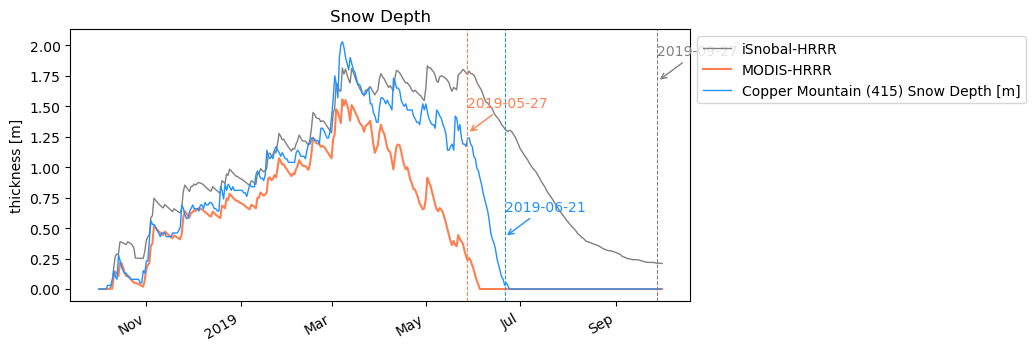

In [ ]:
%%time
figsize = (8, 4)
fig, ax = plt.subplots(1, figsize=figsize)
var_data.plot(ax=ax, color='gray', label='iSnobal-HRRR', linewidth=1)
updated_var_data.plot(ax=ax, color=isnobalcolors[1], label='MODIS-HRRR')

# Plot WY time series of snow depth
(snotel_df[f'{sitename} Snow Depth (cm) End of Day Values']/100).plot(ax=ax, 
                                                                label=f'{sitename} Snow Depth [m]', 
                                                                linestyle=linestyle, 
                                                                linewidth=1,
                                                                color=snotelcolors[0], 
                                                                marker=marker)

# plt.legend(bbox_to_anchor=(1,-0.2), ncol=3, alignment='center')
plt.legend(bbox_to_anchor=(1,1), alignment='center')
plt.title('Snow Depth')
plt.xlabel('')

# Add callouts of disappearance dates with vertical lines
plt.axvline(snotel_sdd, color=snotelcolors[0], linestyle='--', linewidth=0.75, label='SNOTEL SDD')
plt.axvline(classic_sdd, color='gray', linestyle='--', linewidth=0.75, label='iSnobal-HRRR SDD')
plt.axvline(modis_hrrr_sdd, color='coral', linestyle='--', linewidth=0.75, label='MODIS-HRRR SDD')



# Add arrows pointing left towards the vertical lines above, in the same color as the line
# get fraction of max y value for the y position of the arrow
ymax = ax.get_ylim()[1]

plt.annotate(f'{snotel_sdd.strftime("%Y-%m-%d")}', xy=(snotel_sdd, ymax*0.2), xytext=(snotel_sdd, ymax*0.3),
             color=snotelcolors[0], arrowprops=dict(color=snotelcolors[0], arrowstyle='->'))
plt.annotate(f'{classic_sdd.strftime("%Y-%m-%d")}', xy=(classic_sdd, ymax*0.8), xytext=(classic_sdd, ymax*0.9),
             color='gray', arrowprops=dict(color='gray', arrowstyle='->'))
plt.annotate(f'{modis_hrrr_sdd.strftime("%Y-%m-%d")}', xy=(modis_hrrr_sdd, ymax*0.6), xytext=(modis_hrrr_sdd, ymax*0.7),
             color='coral', arrowprops=dict(color='coral', arrowstyle='->'))

Retrieved geodataframe of Copper Mountain (415) SNOTEL site and dataframe for WY 2019
2019-06-21 00:00:00
2019-09-27 22:00:00
2019-06-02 22:00:00
Retrieved geodataframe of Fremont Pass (485) SNOTEL site and dataframe for WY 2019
2019-07-05 00:00:00
2019-09-26 22:00:00
2019-06-25 22:00:00
Retrieved geodataframe of Grizzly Peak (505) SNOTEL site and dataframe for WY 2019
2019-06-20 00:00:00
2019-09-27 22:00:00
2019-06-20 22:00:00


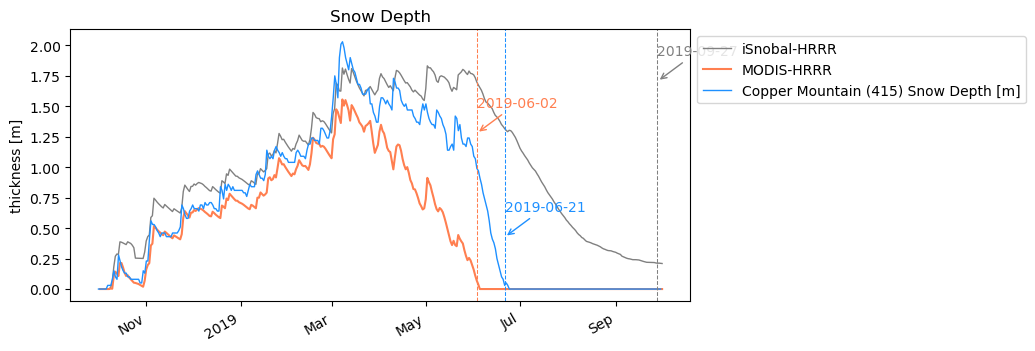

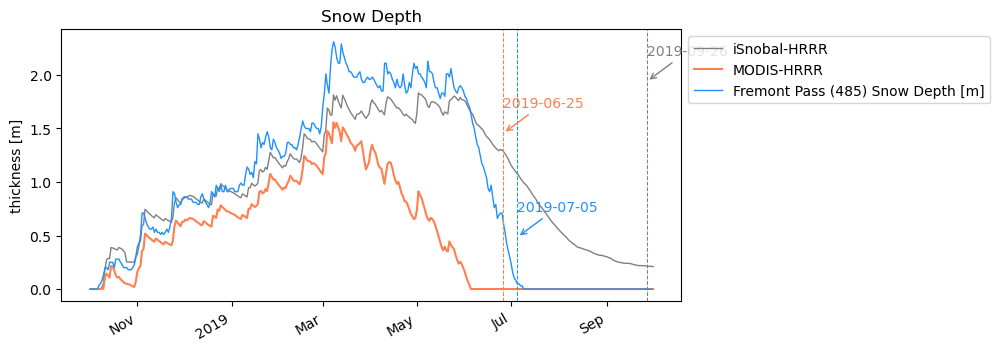

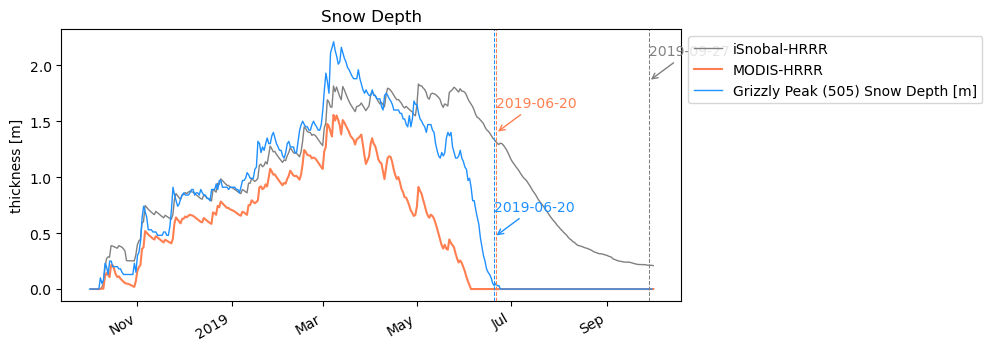

In [ ]:
gdf_dict = dict()
for jdx in range(len(sitenums)):
    snotel_df, gdf, sitenum, sitename = proc.get_snotel_df_pt(snotel_dir=snotel_dir, sitenums=sitenums, WY=WY, jdx=jdx)
    gdf_dict[sitename] = gdf
    snow_var_data = [ds[thisvar].sel(x=list(gdf.geometry.x.values), y=list(gdf.geometry.y.values), method='nearest') for ds in ds_list]
    snow_updated_var_data = [ds[thisvar].sel(x=list(gdf.geometry.x.values), y=list(gdf.geometry.y.values), method='nearest') for ds in ds_sol_list]

    # Concatenate all the days
    snow_var_data = xr.concat(snow_var_data, dim='time')
    snow_updated_var_data = xr.concat(snow_updated_var_data, dim='time')

    # Get disappearance dates
    snow_name = 'Snow Depth'
    verbose = False
    day_thresh = 3
    # Add flexibility for day_thresh values without breaking the code
    try:
        snotel_sdd, _ = proc.calc_sdd(snotel_df[f'{sitename} Snow Depth (cm) End of Day Values']/100, 
                                    snow_name=snow_name, verbose=verbose, day_thresh=day_thresh)
    except:
        print(f"Day threshold {day_thresh} failed, trying lower threshold of {day_thresh-1}")
        day_thresh = day_thresh - 1
        snotel_sdd, _ = proc.calc_sdd(snotel_df[f'{sitename} Snow Depth (cm) End of Day Values']/100, 
                                        snow_name=snow_name, verbose=verbose, day_thresh=day_thresh)
    print(snotel_sdd)
    # Convert model data to Pandas Series
    classic_sdd, _ = proc.calc_sdd(pd.Series(data=np.squeeze(snow_var_data.data), index=snow_var_data.time.values),
                                snow_name=snow_name, verbose=verbose, day_thresh=day_thresh)
    print(classic_sdd)

    # Convert model data to Pandas Series
    modis_hrrr_sdd, _ = proc.calc_sdd(pd.Series(data=np.squeeze(snow_updated_var_data.data), index=snow_updated_var_data.time.values),
                                snow_name=snow_name, verbose=verbose, day_thresh=day_thresh)
    print(modis_hrrr_sdd)

    figsize = (8, 4)
    fig, ax = plt.subplots(1, figsize=figsize)
    var_data.plot(ax=ax, color='gray', label='iSnobal-HRRR', linewidth=1)
    updated_var_data.plot(ax=ax, color=isnobalcolors[1], label='MODIS-HRRR')

    # Plot WY time series of snow depth
    (snotel_df[f'{sitename} Snow Depth (cm) End of Day Values']/100).plot(ax=ax, 
                                                                    label=f'{sitename} Snow Depth [m]', 
                                                                    linestyle=linestyle, 
                                                                    linewidth=1,
                                                                    color=snotelcolors[0], 
                                                                    marker=marker)

    # plt.legend(bbox_to_anchor=(1,-0.2), ncol=3, alignment='center')
    plt.legend(bbox_to_anchor=(1,1), alignment='center')
    plt.title('Snow Depth')
    plt.xlabel('')

    # Add callouts of disappearance dates with vertical lines
    plt.axvline(snotel_sdd, color=snotelcolors[0], linestyle='--', linewidth=0.75, label='SNOTEL SDD')
    plt.axvline(classic_sdd, color='gray', linestyle='--', linewidth=0.75, label='iSnobal-HRRR SDD')
    plt.axvline(modis_hrrr_sdd, color='coral', linestyle='--', linewidth=0.75, label='MODIS-HRRR SDD')

    # Add arrows pointing left towards the vertical lines above, in the same color as the line
    # get fraction of max y value for the y position of the arrow
    ymax = ax.get_ylim()[1]

    plt.annotate(f'{snotel_sdd.strftime("%Y-%m-%d")}', xy=(snotel_sdd, ymax*0.2), xytext=(snotel_sdd, ymax*0.3),
                color=snotelcolors[0], arrowprops=dict(color=snotelcolors[0], arrowstyle='->'))
    plt.annotate(f'{classic_sdd.strftime("%Y-%m-%d")}', xy=(classic_sdd, ymax*0.8), xytext=(classic_sdd, ymax*0.9),
                color='gray', arrowprops=dict(color='gray', arrowstyle='->'))
    plt.annotate(f'{modis_hrrr_sdd.strftime("%Y-%m-%d")}', xy=(modis_hrrr_sdd, ymax*0.6), xytext=(modis_hrrr_sdd, ymax*0.7),
                color='coral', arrowprops=dict(color='coral', arrowstyle='->'))

In [ ]:
print(gdf_dict)

{'Copper Mountain (415)':                          geometry
0  POINT (399388.787 4371808.031), 'Fremont Pass (485)':                          geometry
0  POINT (396646.502 4359633.712), 'Grizzly Peak (505)':                          geometry
0  POINT (425358.761 4389273.436)}
